In [1]:
import pandas as pd

train = pd.read_csv('/kaggle/input/playground-series-s3e20/train.csv')
test = pd.read_csv('/kaggle/input/playground-series-s3e20/test.csv')

In [2]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79023 entries, 0 to 79022
Data columns (total 76 columns):
 #   Column                                                    Non-Null Count  Dtype  
---  ------                                                    --------------  -----  
 0   ID_LAT_LON_YEAR_WEEK                                      79023 non-null  object 
 1   latitude                                                  79023 non-null  float64
 2   longitude                                                 79023 non-null  float64
 3   year                                                      79023 non-null  int64  
 4   week_no                                                   79023 non-null  int64  
 5   SulphurDioxide_SO2_column_number_density                  64414 non-null  float64
 6   SulphurDioxide_SO2_column_number_density_amf              64414 non-null  float64
 7   SulphurDioxide_SO2_slant_column_number_density            64414 non-null  float64
 8   SulphurDioxide_c

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79023 entries, 0 to 79022
Data columns (total 76 columns):
 #   Column                                                    Non-Null Count  Dtype  
---  ------                                                    --------------  -----  
 0   ID_LAT_LON_YEAR_WEEK                                      79023 non-null  object 
 1   latitude                                                  79023 non-null  float64
 2   longitude                                                 79023 non-null  float64
 3   year                                                      79023 non-null  int64  
 4   week_no                                                   79023 non-null  int64  
 5   SulphurDioxide_SO2_column_number_density                  64414 non-null  float64
 6   SulphurDioxide_SO2_column_number_density_amf              64414 non-null  float64
 7   SulphurDioxide_SO2_slant_column_number_density            64414 non-null  float64
 8   SulphurDioxide_c

In [4]:
# Function to cap outliers based on the IQR method
def cap_outliers(df):
    for column in df.select_dtypes(include=['float64', 'int64']).columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df[column] = df[column].clip(lower=lower_bound, upper=upper_bound)
    return df

# Capping outliers in both datasets
new_train = cap_outliers(train)
new_test = cap_outliers(test)

In [5]:
numeric_train = new_train.select_dtypes(include=['float64', 'int64'])
correlations = numeric_train.corr()['emission'].sort_values(ascending=False)
correlations

emission                                                    1.000000
longitude                                                   0.229384
Formaldehyde_tropospheric_HCHO_column_number_density_amf    0.105125
Cloud_surface_albedo                                        0.071812
UvAerosolLayerHeight_aerosol_height                         0.066327
                                                              ...   
CarbonMonoxide_cloud_height                                -0.052912
Formaldehyde_tropospheric_HCHO_column_number_density       -0.057222
UvAerosolLayerHeight_aerosol_pressure                      -0.059634
CarbonMonoxide_CO_column_number_density                    -0.082754
CarbonMonoxide_H2O_column_number_density                   -0.091116
Name: emission, Length: 75, dtype: float64

In [6]:
# Select features with positive correlation
positive_correlations = correlations[correlations > 0].drop('emission')
features = positive_correlations.index.tolist()
features

['longitude',
 'Formaldehyde_tropospheric_HCHO_column_number_density_amf',
 'Cloud_surface_albedo',
 'UvAerosolLayerHeight_aerosol_height',
 'latitude',
 'UvAerosolLayerHeight_aerosol_optical_depth',
 'NitrogenDioxide_cloud_fraction',
 'SulphurDioxide_SO2_column_number_density_amf',
 'UvAerosolLayerHeight_sensor_azimuth_angle',
 'NitrogenDioxide_absorbing_aerosol_index',
 'Ozone_O3_column_number_density',
 'week_no',
 'SulphurDioxide_cloud_fraction',
 'UvAerosolIndex_sensor_azimuth_angle',
 'Ozone_sensor_azimuth_angle',
 'UvAerosolLayerHeight_solar_zenith_angle',
 'UvAerosolLayerHeight_sensor_zenith_angle',
 'Cloud_sensor_azimuth_angle',
 'Formaldehyde_cloud_fraction',
 'Cloud_cloud_base_pressure',
 'UvAerosolIndex_absorbing_aerosol_index',
 'Cloud_cloud_top_pressure',
 'NitrogenDioxide_sensor_altitude']

In [7]:
target = 'emission'

In [8]:
# One-hot encoding categorical variables in both datasets
categorical_columns_train = new_train.select_dtypes(include=['object']).columns
categorical_columns_test = new_test.select_dtypes(include=['object']).columns

# Apply one-hot encoding
new_train = pd.get_dummies(new_train, columns=categorical_columns_train, drop_first=True)
new_test = pd.get_dummies(new_test, columns=categorical_columns_test, drop_first=True)

In [9]:
new_train.fillna(0, inplace=True)
new_test.fillna(0, inplace=True)

In [10]:
# Splitthe training dataset into train and validation sets
X = new_train[features]
X_test = new_test[features]
y = new_train[target]

In [11]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=42)

X_train.shape, X_val.shape, y_train.shape, y_val.shape

((59267, 23), (19756, 23), (59267,), (19756,))

In [12]:
%%time

from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import numpy as np

# Initialize KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Initialize the scaler
scaler = StandardScaler()

# Initialize the model
model = xgb.XGBRegressor(objective='reg:squarederror')

rmse_scores = []

for train_index, val_index in kf.split(X_train):
    # Split the data into training and validation sets
    X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

    # Scale the features
    X_train_fold_scaled = scaler.fit_transform(X_train_fold)
    X_val_fold_scaled = scaler.transform(X_val_fold)

    # Train the model
    model.fit(X_train_fold_scaled, y_train_fold)

    # Make predictions on the validation set
    y_val_pred = model.predict(X_val_fold_scaled)

    # Evaluate RMSE
    rmse = np.sqrt(mean_squared_error(y_val_fold, y_val_pred))
    rmse_scores.append(rmse)

# Calculate the average RMSE
average_rmse = np.mean(rmse_scores)
average_rmse

CPU times: user 14.6 s, sys: 97.6 ms, total: 14.7 s
Wall time: 4.02 s


15.189270453547305

In [13]:
# Scale the test dataset
X_test_scaled = scaler.transform(X_test)

In [14]:
# Make predictions on the test dataset
y_test_pred = model.predict(X_test_scaled)

In [16]:
# Add predicted carbon emissions to the test dataset
new_test['predicted_emission'] = y_test_pred

In [17]:
# Calculating the percentage of predicted carbon emissions for each week at each location
percentage_emissions = new_test.groupby(['longitude', 'latitude', 'week_no'])['predicted_emission'].sum() / new_test['predicted_emission'].sum() * 100

percentage_emissions = percentage_emissions.reset_index(name='percentage_emission')
percentage_emissions

,longitude,latitude,week_no,percentage_emission
0,28.228,-2.972,0,0.000196
1,28.228,-2.972,1,0.000187
2,28.228,-2.972,2,0.000171
3,28.228,-2.972,3,0.000305
4,28.228,-2.972,4,0.000221
...,...,...,...,...
24348,31.532,-1.068,44,0.013175
24349,31.532,-1.068,45,0.013161
24350,31.532,-1.068,46,0.013372
24351,31.532,-1.068,47,0.011824


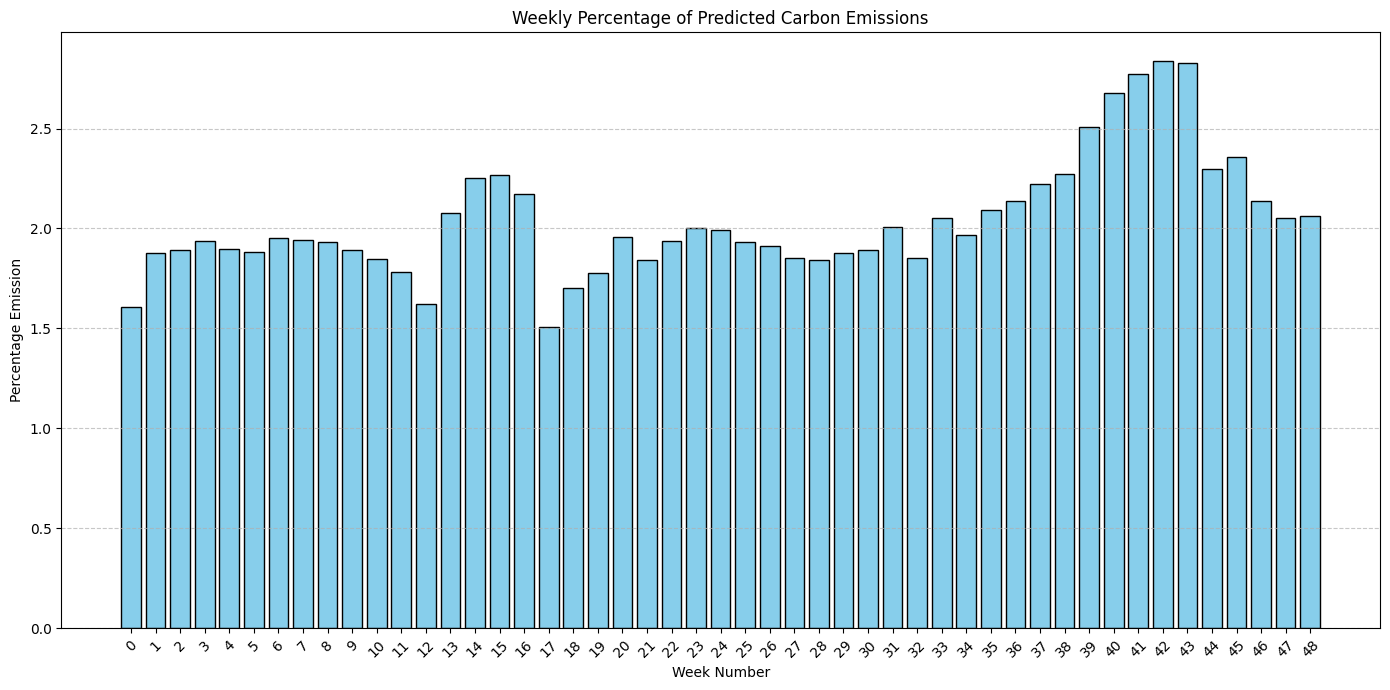

In [18]:
import matplotlib.pyplot as plt

# Create a bar graph to visualize the percentage of predicted carbon emissions for each week
plt.figure(figsize=(14, 7))

# Aggregate emissions by week
weekly_emissions = percentage_emissions.groupby('week_no')['percentage_emission'].sum().reset_index()

# Bar plot
plt.bar(weekly_emissions['week_no'], weekly_emissions['percentage_emission'], color='skyblue', edgecolor='black')

plt.title('Weekly Percentage of Predicted Carbon Emissions')
plt.xlabel('Week Number')
plt.ylabel('Percentage Emission')
plt.xticks(weekly_emissions['week_no'], rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [20]:
import joblib

# Save the trained pipeline to a .pkl file
joblib.dump(model, 'co2_emission_model.pkl')

['co2_emission_model.pkl']